In [1]:
import copy
import h5py
import numpy as np
import os
import pandas as pd
import sys
import scipy.interpolate
import tqdm
import unyt
import verdict

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import palettable

In [3]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.astro as astro_tools

In [5]:
import luminosity_yu

In [6]:
import linefinder.utils.file_management as file_management_old
import linefinder.utils.file_management_new as file_management
import linefinder.config as config

In [7]:
import trove

# Load Data

### Parameters

In [8]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    variation = 'm11d_md',
)

In [9]:
# Halo file params
mt_kwargs = {
    'tag': 'smooth',
}

In [10]:
# Data selection params
snum = 600
t_window = 1. # In Gyr
galdef = ''
galaxy_cut = 0.1
length_scale = 'Rvir'

In [11]:
store_child_ids = False

### Get Data Structures

In [12]:
fm = file_management.FileManager( 'hot_accretion' )
fm_old = file_management_old.FileManager( 'hot_accretion' )

In [13]:
ind = 600 - snum

In [14]:
g_data = particle_data.ParticleData(
    sdir = pm['sim_data_dir'],
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = pm['halo_data_dir'],
    main_halo_id = 0,
    load_additional_ids = store_child_ids,
)

In [15]:
s_data = particle_data.ParticleData(
    sdir = pm['sim_data_dir'],
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = pm['halo_data_dir'],
    main_halo_id = 0,
    load_additional_ids = store_child_ids,
)

In [16]:
# Load a time data array
time = astro_tools.age_of_universe(
    g_data.halo_data.get_mt_data( 'redshift', ),
    h = g_data.data_attrs['hubble'],
    omega_matter = g_data.data_attrs['omega_matter'],
)

In [17]:
# Find the time
prev_time_inds = np.arange(time.size)[np.isclose( time[ind] - t_window, time, atol=0.012 )]
assert prev_time_inds.size == 1
prev_time_ind = prev_time_inds[0]
snum_prior = 600 - prev_time_ind

In [18]:
g_data_prior = particle_data.ParticleData(
    sdir = pm['sim_data_dir'],
    snum = snum_prior,
    ptype = config.PTYPE_GAS,
    halo_data_dir = pm['halo_data_dir'],
    main_halo_id = 0,
    load_additional_ids = store_child_ids,
)

# Select Data

### Particles in the Galaxy Later

In [19]:
# Find characteristic length scale of the galaxy
len_scale = g_data.halo_data.get_mt_data(
    length_scale,
    snums=[snum,],
    mt_halo_id=g_data.main_halo_id
)
r_gal = galaxy_cut * len_scale

In [20]:
# Find gas particles in the main galaxy
is_in_gal_gas = (
    ( g_data.get_data( 'R' ) < r_gal ) &
    ( g_data.get_data( 'Den' ) > config.GALAXY_DENSITY_CUT )
)

In [21]:
# Find star particles in the main galaxy
is_in_gal_star = s_data.get_data( 'R' ) < r_gal

In [22]:
# Retrieve the relevant IDs
ids_gal = np.concatenate(
    (
        g_data.get_data( 'ID' )[is_in_gal_gas],
        s_data.get_data( 'ID' )[is_in_gal_star]
    )
)

In [23]:
if store_child_ids:
    child_ids_gal = np.concatenate(
        (
            g_data.get_data( 'ChildID' )[is_in_gal_gas],
            s_data.get_data( 'ChildID' )[is_in_gal_star]
        )
    )

### Particles in the CGM Earlier

In [24]:
# Find the CGM inner edge
len_scale_prior = g_data_prior.halo_data.get_mt_data(
    config.LENGTH_SCALE,
    snums=[snum_prior,],
    mt_halo_id=g_data.main_halo_id
)
cgm_inner_scale = 1.2 * config.GALAXY_CUT * len_scale_prior
cgm_inner_rvir = config.INNER_CGM_BOUNDARY * g_data_prior.r_vir
cgm_inner = max( cgm_inner_scale, cgm_inner_rvir )

In [25]:
is_in_CGM = g_data_prior.get_data( 'R' ) > cgm_inner

In [26]:
ids_cgm = g_data_prior.get_data( 'ID' )[is_in_CGM]

In [27]:
if store_child_ids:
    child_ids_cgm = g_data_prior.get_data( 'ChildID' )[is_in_CGM]

### Particles that Accreted

In [28]:
ids_accreted_alt = np.intersect1d( ids_gal, ids_cgm )

In [29]:
if store_child_ids:
    ids_str_gal = [ '{}_{}'.format( ids_gal[i], child_ids_gal[i] ) for i in range( ids_gal.size ) ]
    ids_str_cgm = [ '{}_{}'.format( ids_cgm[i], child_ids_cgm[i] ) for i in range( ids_cgm.size ) ]
    ids_str_accreted = np.intersect1d( ids_str_gal, ids_str_cgm )
    ids_accreted, child_ids_accreted = np.array( [ _.split( '_' ) for _ in ids_str_accreted ] ).astype( int ).transpose()
else:
    ids_accreted = ids_accreted_alt

In [30]:
if store_child_ids:
    extra_ids = np.array( list( set( ids_accreted_alt ) - set( ids_accreted ) ) )

# Plot Selected Data

## After

### Get Spatial Data

In [31]:
# Format Gas Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz', 'Den' ]:
    data[key] = g_data.get_data( key )
df = pd.DataFrame( data )

# Get rid of duplicates
df = df.drop_duplicates( 'ID', keep=False )

df = df.set_index( 'ID' )

In [32]:
is_acc = df.index.isin( ids_accreted )
df_acc = df[is_acc]

In [33]:
if store_child_ids:
    is_extra = df.index.isin( extra_ids )
    df_extra = df[is_extra]

In [34]:
# Format Star Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz' ]:
    data[key] = s_data.get_data( key )
df_star = pd.DataFrame( data )

# Get rid of duplicates
df_star = df_star.drop_duplicates( 'ID', keep=False )

df_star = df_star.set_index( 'ID' )

In [35]:
is_acc_star = df_star.index.isin( ids_accreted )
df_acc_star = df_star[is_acc_star]

In [36]:
if store_child_ids:
    is_extra = df_star.index.isin( extra_ids )
    df_extra_star = df_star[is_extra]

### Plot After

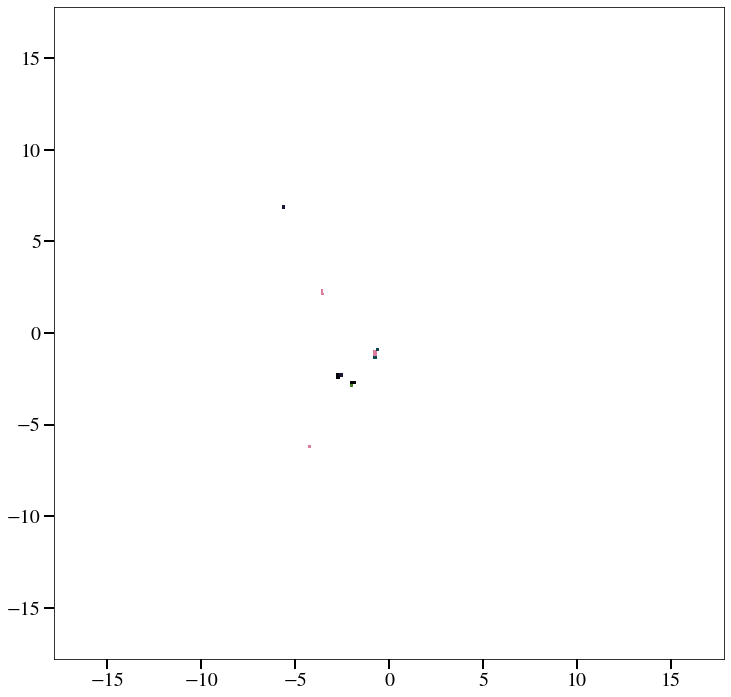

In [37]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_acc['Rx'],
    df_acc['Ry'],
    bins = 256,
    range = 1.5 * r_gal * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

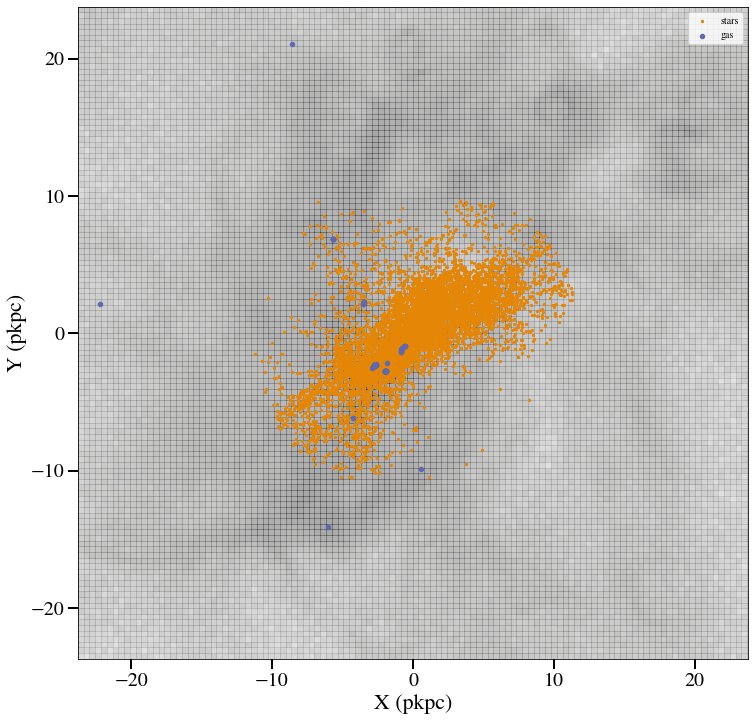

In [38]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    g_data.get_data( 'Rx' ),
    g_data.get_data( 'Ry' ),
    bins = 256,
    range = 0.3 * g_data.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.4,
)

ax.scatter(
    df_acc_star['Rx'],
    df_acc_star['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
    s = 5,
    label = 'stars',
)

ax.scatter(
    df_acc['Rx'],
    df_acc['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 20,
    label = 'gas',
)


ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -2. * r_gal, 2. * r_gal )
ax.set_ylim( -2. * r_gal, 2. * r_gal )

ax.legend()

fig

In [39]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.hist2d(
        df_extra['Rx'],
        df_extra['Ry'],
        bins = 128,
        range = 1.5 * r_gal * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
        cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
        norm = plt_colors.LogNorm(),
    )

    fig

In [40]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.scatter(
        df_extra['Rx'],
        df_extra['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
        s = 25,
        label = 'gas',
    )
    
    ax.scatter(
        df_extra_star['Rx'],
        df_extra_star['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
        s = 5,
        label = 'stars',
    )


    ax.set_xlabel( 'X (pkpc)', fontsize=22, )
    ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

    ax.set_xlim( -1. * r_gal, 1. * r_gal )
    ax.set_ylim( -1. * r_gal, 1. * r_gal )

    ax.legend()

    fig

## Check Results of Splitting

In [41]:
if store_child_ids:

    g_dups = g_data.find_duplicate_ids()

    s_dups = s_data.find_duplicate_ids()

    gs_dups = np.intersect1d( g_data.get_data( 'ID' ), s_data.get_data( 'ID' ) )

    all_dups = np.union1d( np.union1d( g_dups, s_dups, ), gs_dups )
    
    g_prior_dups = g_data_prior.find_duplicate_ids()

In [42]:
if store_child_ids:

    print( 'Percent of galaxy ids with duplicates = {:.2g}%'.format( np.intersect1d( all_dups, ids_gal ).size / ids_gal.size * 100 ) )

    print( 'Percent of CGM ids with duplicates = {:.2g}%'.format( np.intersect1d( ids_cgm, g_prior_dups ).size / ids_cgm.size * 100 ) )

    print( 'Percent of galaxy ids targeted = {:.2g}%'.format( ids_accreted.size / ids_gal.size * 100 ) )

    print( 'Percent of CGM ids targeted = {:.2g}%'.format( ids_accreted.size / ids_cgm.size * 100 ) )

    n_dups = np.intersect1d( ids_accreted_alt, all_dups ).size

    cgm_before_dup_after = np.intersect1d( ids_cgm, np.intersect1d( all_dups, ids_gal ) )

    dup_before_gal_after = np.intersect1d( ids_gal, np.intersect1d( g_prior_dups, ids_cgm ) )

    dup_before_dup_after = np.intersect1d( np.intersect1d( all_dups, ids_gal ), np.intersect1d( g_prior_dups, ids_cgm )  )

    all_relevant_dup_ids = np.union1d( np.union1d( cgm_before_dup_after, dup_before_gal_after ), dup_before_dup_after )
    
    print( 'Percent of duplicates CGM before, duplicate after = {:.2g}%'.format( cgm_before_dup_after.size / n_dups * 100 ) )

    print( 'Percent of duplicates duplicate before, galaxy after = {:.2g}%'.format( dup_before_gal_after.size / n_dups * 100 ) )

    print( 'Accounted for IDs = {}, number of duplicate IDs = {}'.format( all_relevant_dup_ids.size, np.intersect1d( ids_accreted_alt, all_dups ).size ) )

## Before

### Get Spatial Data

In [43]:
# Format Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz' ]:
    data[key] = g_data_prior.get_data( key )
data['is_in_CGM'] = is_in_CGM
df_prior = pd.DataFrame( data )

# Get rid of duplicates
df_prior = df_prior.drop_duplicates( 'ID', keep=False )

df_prior = df_prior.set_index( 'ID' )

In [44]:
df_acc_prior = df_prior[df_prior.index.isin( ids_accreted )]

In [45]:
not_counted = df.index.isin( df_prior.index[df_prior['is_in_CGM']] ) & np.invert( is_acc )
df_not_counted = df[not_counted]

In [46]:
not_counted = df_star.index.isin( df_prior.index[df_prior['is_in_CGM']] ) & np.invert( is_acc_star )
df_not_counted_star = df_star[not_counted]

In [47]:
if store_child_ids:
    df_extra_prior = df_prior[df_prior.index.isin( extra_ids )]

### Plot Before

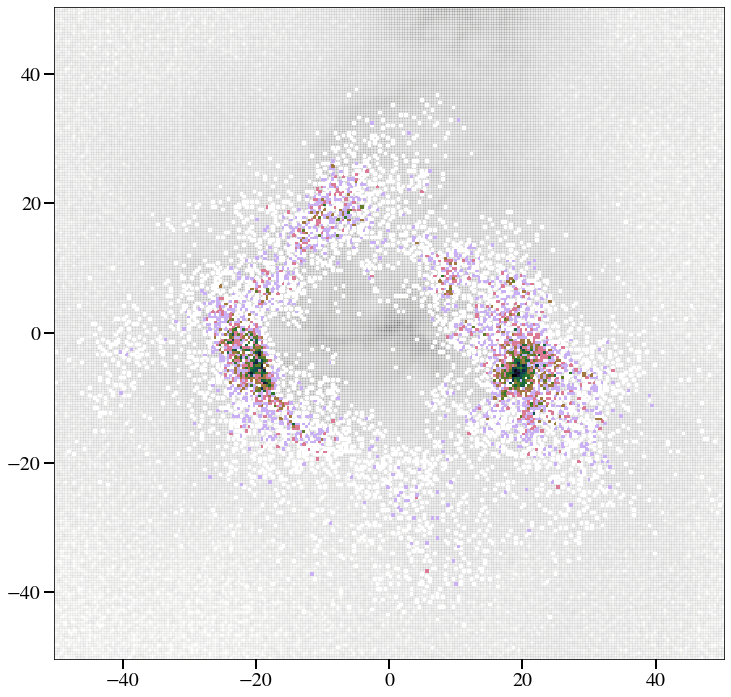

In [48]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    g_data_prior.get_data( 'Rx' ),
    g_data_prior.get_data( 'Ry' ),
    bins = 256,
    range = 0.3 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.2,
)

ax.hist2d(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    bins = 256,
    range = 0.3 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

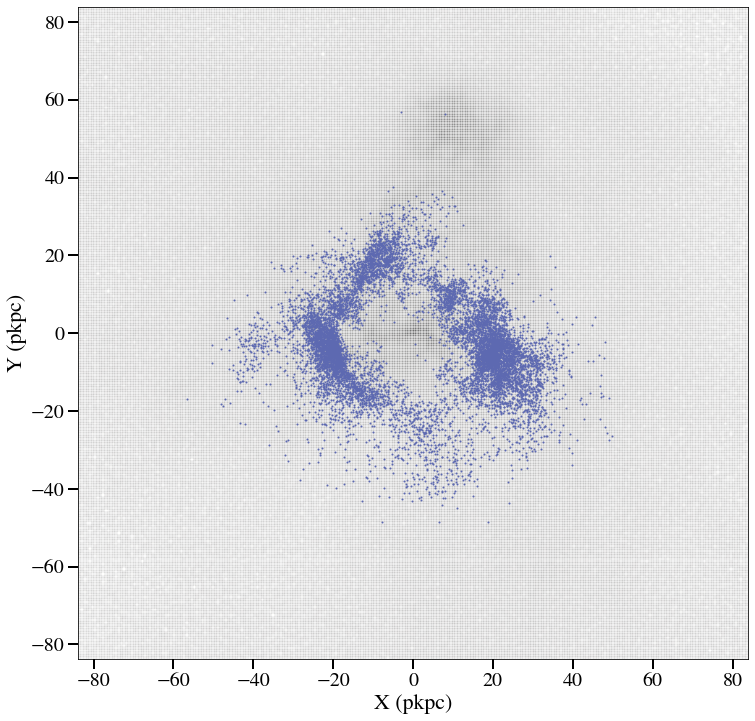

In [49]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    g_data_prior.get_data( 'Rx' ),
    g_data_prior.get_data( 'Ry' ),
    bins = 256,
    range = 0.5 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.2,
)

ax.scatter(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 1,
)

ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )
ax.set_ylim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )

fig

In [50]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.scatter(
        df_extra_prior['Rx'],
        df_extra_prior['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
        s = 1,
    )

    ax.set_xlabel( 'X (pkpc)', fontsize=22, )
    ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

    ax.set_xlim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )
    ax.set_ylim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )

    fig

### Plot Positions at $z=0$

In [51]:
df_not_counted['R'] = np.sqrt( df_not_counted['Rx']**2. + df_not_counted['Ry']**2. + df_not_counted['Rz']**2. )

<ipython-input-51-2c93706def20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_counted['R'] = np.sqrt( df_not_counted['Rx']**2. + df_not_counted['Ry']**2. + df_not_counted['Rz']**2. )


In [52]:
df_not_counted_star['R'] = np.sqrt( df_not_counted_star['Rx']**2. + df_not_counted_star['Ry']**2. + df_not_counted_star['Rz']**2. )

<ipython-input-52-278ea6e0f05d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_counted_star['R'] = np.sqrt( df_not_counted_star['Rx']**2. + df_not_counted_star['Ry']**2. + df_not_counted_star['Rz']**2. )


In [53]:
print( 'r_star_min_not_counted = {:.3g} kpc; r_gal = {:.3g} kpc'.format( df_not_counted_star['R'].min(), r_gal[0] ) )
assert df_not_counted_star['R'].min() > r_gal, 'r_star_min_not_counted too small'

r_star_min_not_counted = 11.9 kpc; r_gal = 11.9 kpc


In [54]:
in_rgal = df_not_counted['R'] < r_gal[0]
is_dense = df_not_counted['Den'] > config.GALAXY_DENSITY_CUT
in_gal_not_counted = in_rgal & is_dense
assert in_gal_not_counted.sum() == 0

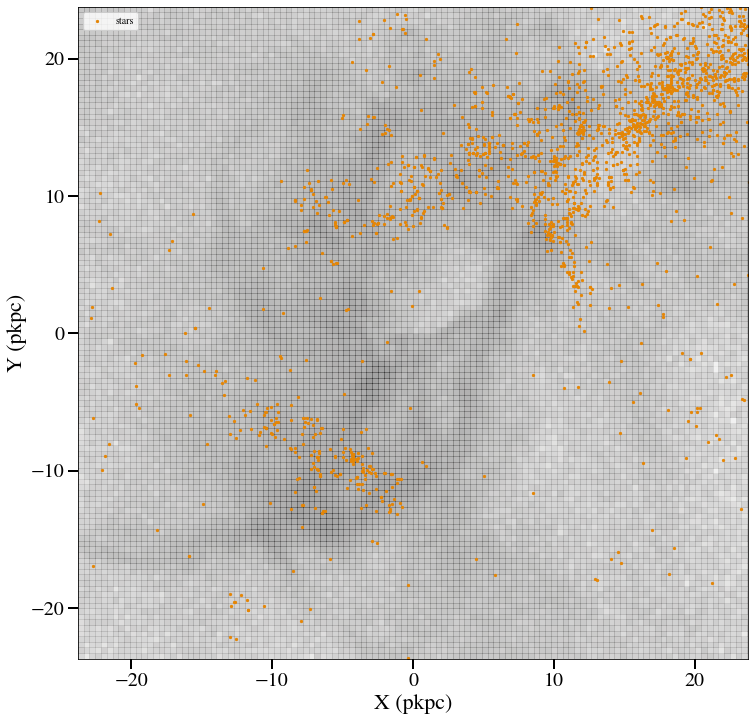

In [55]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_not_counted['Rx'],
    df_not_counted['Ry'],
    bins = 256,
    range = 0.3 * g_data.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.4,
)

ax.scatter(
    df_not_counted_star['Rx'],
    df_not_counted_star['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
    s = 5,
    label = 'stars',
)


ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -2. * r_gal, 2. * r_gal )
ax.set_ylim( -2. * r_gal, 2. * r_gal )

ax.legend()

fig

# Save Data

## ID Data

In [56]:
child_ids_str = {
    True: '_split',
    False: '',
}[store_child_ids]

In [57]:
file_name = 'ids_full_hothaloacc{}.hdf5'.format( child_ids_str )
file_path = os.path.join( pm['data_dir'], file_name )
g = h5py.File( file_path, 'w' )

In [58]:
g.create_dataset( 'target_ids', data=ids_accreted )

<HDF5 dataset "target_ids": shape (10878,), type "<i8">

In [59]:
if store_child_ids:
    g.create_dataset( 'target_child_ids', data=child_ids_accreted )

In [60]:
g.close()

In [61]:
print( 'Saved at {}'.format( file_path ) )

Saved at /scratch/03057/zhafen/hot_accretion_data/m11d_md/ids_full_hothaloacc.hdf5


## Summary Statistics Data

### Momentum

In [62]:
tot_momentum_fp = os.path.join( pm['processed_data_dir'], 'tot_momentums.hdf5' )

In [63]:
try:
    tot_momentums = verdict.Dict.from_hdf5( tot_momentum_fp )
except IOError:
    tot_momentums = verdict.Dict( {} )

In [64]:
sim_str = pm['variation']
if sim_str not in tot_momentums:
    tot_momentums[pm['variation']] = {}

In [65]:
tot_momentums[sim_str]['snum{:03d}'.format( snum )] = s_data.total_ang_momentum

In [66]:
tot_momentums[sim_str]['snum{:03d}'.format( snum_prior )] = g_data_prior.total_ang_momentum

In [67]:
tot_momentums.to_hdf5( tot_momentum_fp )

The angles are consistent both across time and stars/gas:

In [68]:
print(
        'Change between gas angular momentum now and 1 Gyr ago: {:.2g} degrees'.format(
        np.arccos(
            np.dot(
                g_data.total_ang_momentum / np.linalg.norm( g_data.total_ang_momentum ),
                g_data_prior.total_ang_momentum / np.linalg.norm( g_data_prior.total_ang_momentum ),
            )
        ) / np.pi * 180.
    )
)

Change between gas angular momentum now and 1 Gyr ago: 37 degrees


In [69]:
print(
        'Change between gas angular momentum now and stellar angular momentum now: {:.2g} degrees'.format(
        np.arccos(
            np.dot(
                g_data.total_ang_momentum / np.linalg.norm( g_data.total_ang_momentum ),
                s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum ),
            )
        ) / np.pi * 180.
    )
)

Change between gas angular momentum now and stellar angular momentum now: 70 degrees


### Disk Fraction

In [70]:
h_param = s_data.data_attrs['hubble']

In [71]:
# Star masses enclosed
r_star = s_data.get_data( 'R' )[is_in_gal_star]
r_star[r_star > s_data.r_vir] = np.nan
r_star_ckpc = r_star / ( h_param * ( 1. + s_data.redshift ) )
M_enc_star = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_star_ckpc
) / h_param

In [72]:
# Get grid masses enclose
r_grid = np.linspace( 0.00001, s_data.r_vir, 1024 )
r_grid_ckpc = r_grid / ( h_param * ( 1. + s_data.redshift ) )
M_enc_grid = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_grid_ckpc
) / h_param
M_enc_grid[np.isnan(M_enc_grid)] = 0.
M_enc_grid[np.arange(M_enc_grid.size)>np.argmax(M_enc_grid)] = M_enc_grid.max()

In [73]:
# Get potential energy
pot_grid = unyt.G * scipy.integrate.cumtrapz( M_enc_grid/r_grid**2., r_grid, initial=0 ) * unyt.Msun / unyt.kpc
pot_grid -= pot_grid[-1]
pot_grid -= unyt.G * g_data.m_vir * unyt.Msun / ( g_data.r_vir * unyt.kpc )
pot_grid = pot_grid.to( 'm**2/s**2' )
pot_fn = lambda x : scipy.interpolate.interp1d( r_grid, pot_grid )( x ) * unyt.m**2. / unyt.s**2.

In [74]:
# Get energy for a grid, using virial theorem
spec_e_grid = pot_grid + 0.5 * unyt.G * M_enc_grid * unyt.Msun / ( r_grid * unyt.kpc )

In [75]:
# Star potential energy, specific energy
pot_star = pot_fn( r_star )
v_star = s_data.get_data( 'Vmag' )[is_in_gal_star] * unyt.km / unyt.s
spec_e_star =  pot_star +  0.5 * v_star**2.

In [76]:
# What radii particles would be at if they were circular with the same energy
spec_e_star[spec_e_star>spec_e_grid.max()] = np.nan
r_circ = scipy.interpolate.interp1d( spec_e_grid, r_grid )( spec_e_star )

In [77]:
# Circular momentum
r_circ_ckpc = r_circ / ( h_param * ( 1. + s_data.redshift ) )
M_enc_circ = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_circ_ckpc
) / h_param
j_circ = np.sqrt( unyt.G * M_enc_circ * unyt.Msun * r_circ * unyt.kpc)

In [78]:
# Angular momentum
ang_mom_dir = s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum )
l_units = unyt.Msun * unyt.kpc * unyt.km / unyt.s
lz_star = np.dot( s_data.get_data( 'L', ).transpose(), ang_mom_dir )[is_in_gal_star] * l_units
lmag_star = s_data.get_data( 'Lmag' )[is_in_gal_star] * l_units
m_star = s_data.get_data( 'M' )[is_in_gal_star] * unyt.Msun
jz_star = lz_star / m_star
jmag_star = lmag_star / m_star

In [79]:
# Ratios
jz_jcirc = jz_star / j_circ
jz_jmag = jz_star / jmag_star

In [80]:
bins = np.linspace( -1, 1, 256 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

#### Disk Fraction for All Stars

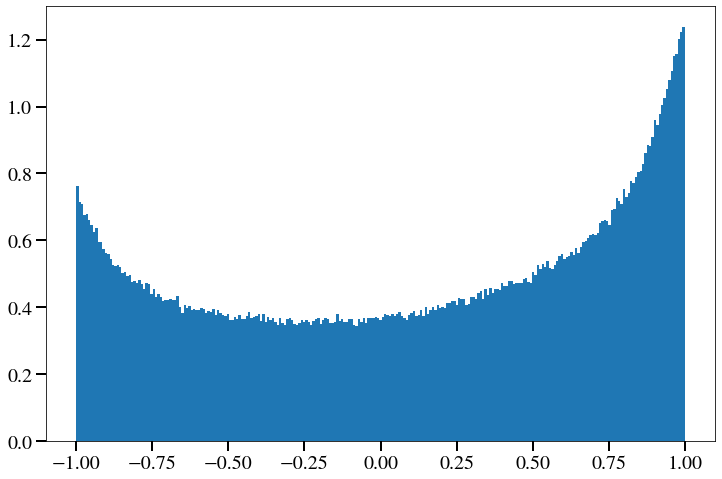

In [81]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

hist, bins, _ = ax.hist(
    jz_jmag,
    bins,
    density = True,
)
fig

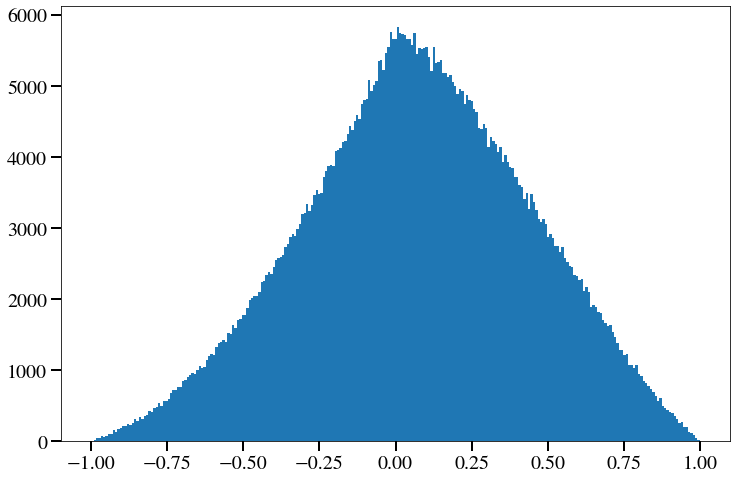

In [82]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jz_jcirc,
    bins,
)
fig

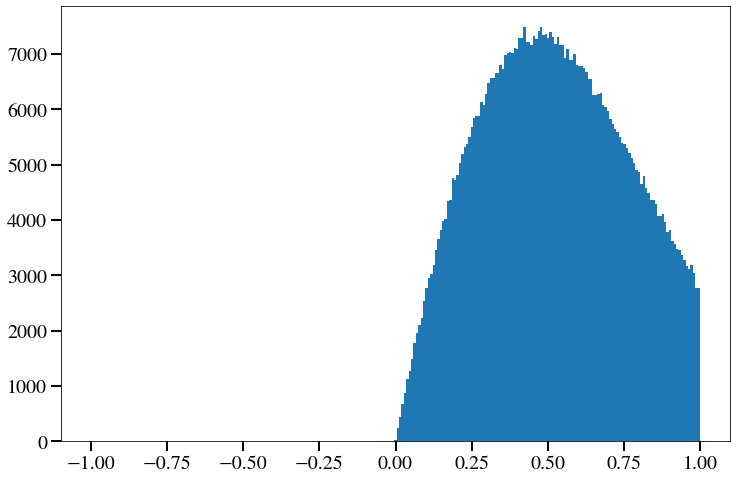

In [83]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jmag_star / j_circ,
    bins,
)
fig

In [84]:
# Calculate fractions
m_tot = m_star.sum()
is_thin_disk = jz_jcirc>=0.8
is_thick_disk = (jz_jcirc>=0.2) & (jz_jcirc<0.8)
is_disk = jz_jcirc>=0.5
thin_disk_frac = m_star[is_thin_disk].sum() / m_tot
thick_disk_frac = m_star[is_thick_disk].sum() / m_tot
disk_frac = m_star[is_disk].sum() / m_tot

In [85]:
# Open for saving
summary_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
summary_data = verdict.Dict.from_hdf5( summary_fp, create_nonexistent=True )

In [86]:
# Store
if 'thin_disk_fraction' not in summary_data.keys():
    summary_data['thin_disk_fraction'] = {}
summary_data['thin_disk_fraction'][pm['variation']] = thin_disk_frac
if 'thick_disk_fraction' not in summary_data.keys():
    summary_data['thick_disk_fraction'] = {}
summary_data['thick_disk_fraction'][pm['variation']] = thick_disk_frac
summary_data.to_hdf5( summary_fp )

In [87]:
if 'jz_jmag_stars' not in summary_data.keys():
    summary_data['jz_jmag_stars'] = {
        'thin_disk': {},
        'thin_disk_recent': {},
        'thin_disk_sloanr': {},
        'centers': {},
        'bins': {},
    }
summary_data['jz_jmag_stars']['bins'][pm['variation']] = bins
summary_data['jz_jmag_stars']['centers'][pm['variation']] = centers

In [88]:
summary_data['jz_jmag_stars']['thin_disk'][pm['variation']] = hist

#### Disk Fraction for Recent Stars

In [89]:
z_star = ( 1. / s_data.get_data( 'Age' ) - 1. )
universe_age = astro_tools.age_of_universe( z_star, h_param, s_data.data_attrs['omega_matter'])
lookback_time = astro_tools.age_of_universe( 0., h_param, s_data.data_attrs['omega_matter']) - universe_age
recent = lookback_time < 1.
recent_in_gal = recent[is_in_gal_star]

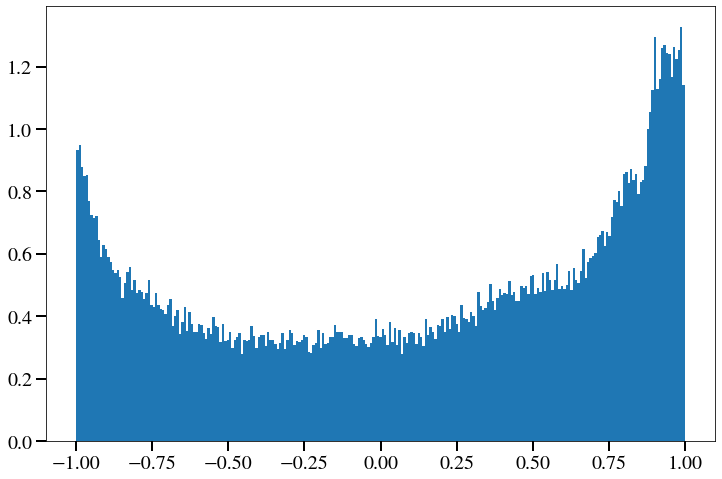

In [90]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

hist, bins, _ = ax.hist(
    jz_jmag[recent_in_gal],
    bins,
    density = True,
)
fig

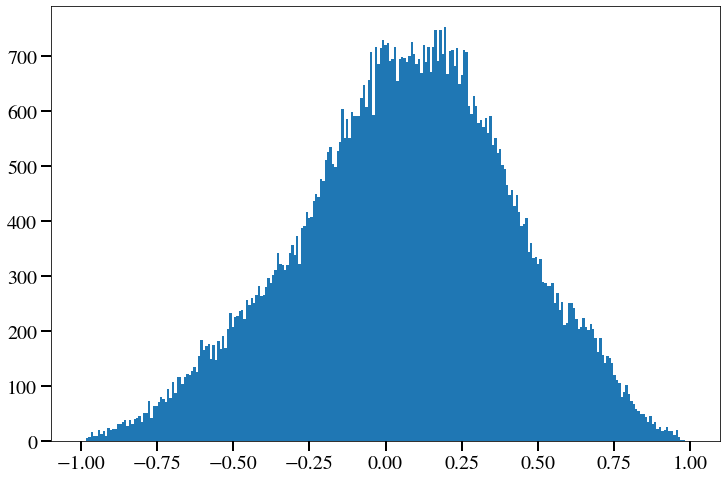

In [91]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jz_jcirc[recent_in_gal],
    bins,
)
fig

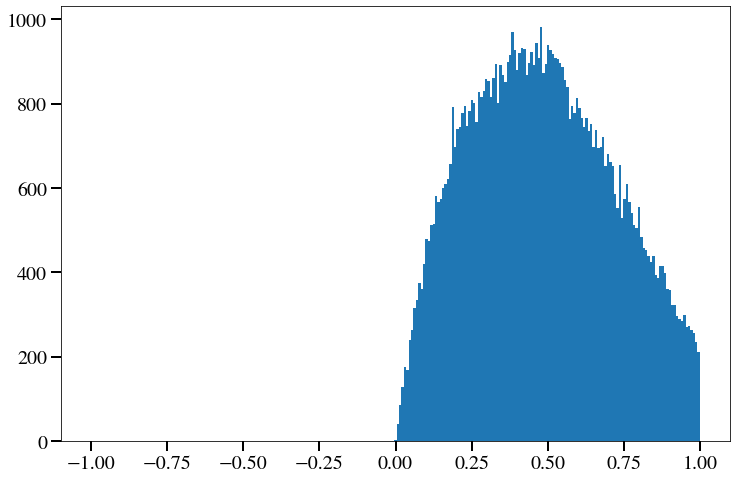

In [92]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    ( jmag_star / j_circ )[recent_in_gal],
    bins,
)
fig

In [93]:
# Calculate fractions
m_tot = m_star[recent_in_gal].sum()
thin_disk_frac = m_star[is_thin_disk & recent_in_gal].sum() / m_tot
thick_disk_frac = m_star[is_thick_disk & recent_in_gal].sum() / m_tot

In [94]:
# Store
if 'thin_disk_fraction_recent' not in summary_data.keys():
    summary_data['thin_disk_fraction_recent'] = {}
summary_data['thin_disk_fraction_recent'][pm['variation']] = thin_disk_frac
if 'thick_disk_fraction_recent' not in summary_data.keys():
    summary_data['thick_disk_fraction_recent'] = {}
summary_data['thick_disk_fraction_recent'][pm['variation']] = thick_disk_frac

In [95]:
summary_data['jz_jmag_stars']['thin_disk_recent'][pm['variation']] = hist

#### Disk Fraction for Luminous Stars

In [96]:
luminosity = luminosity_yu.get_attenuated_stellar_luminosities(
    BAND_IDS = [ 3, ],
    stellar_age = lookback_time,
    stellar_metallicity = s_data.get_data( 'Z' ),
    stellar_mass = s_data.get_data( 'M' ),
)[0]
luminosity_in_gal = luminosity[is_in_gal_star]

Calculating M/L in Sloan r (3,3)


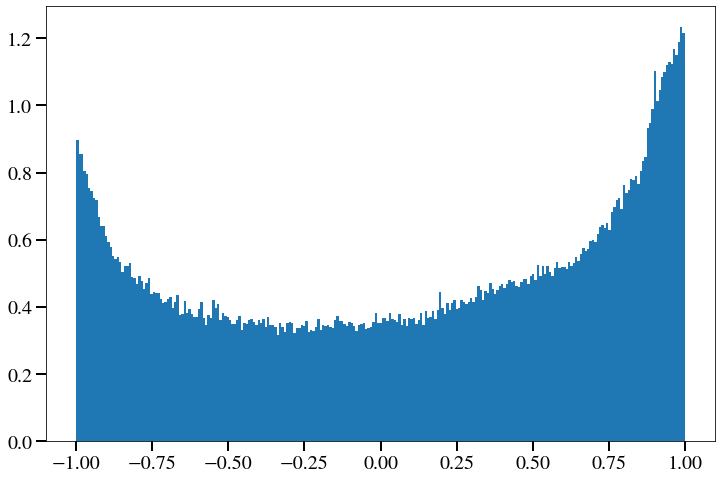

In [97]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

hist, bins, _ = ax.hist(
    jz_jmag,
    bins,
    weights = luminosity_in_gal,
    density = True,
)
fig

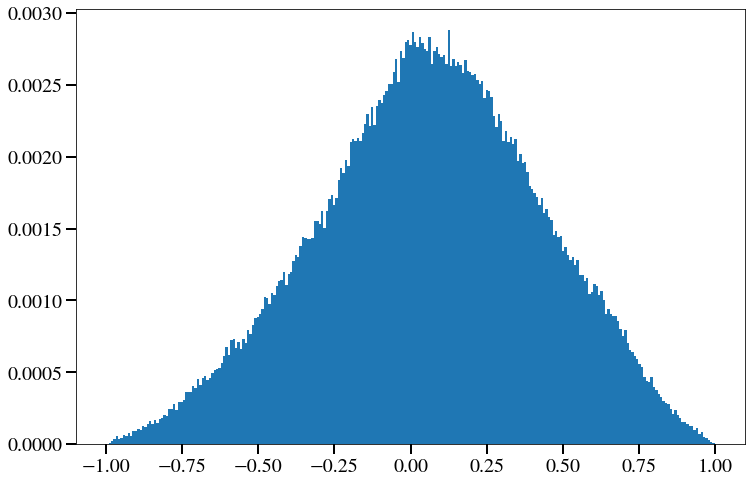

In [98]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jz_jcirc,
    bins,
    weights = luminosity_in_gal,
)
fig

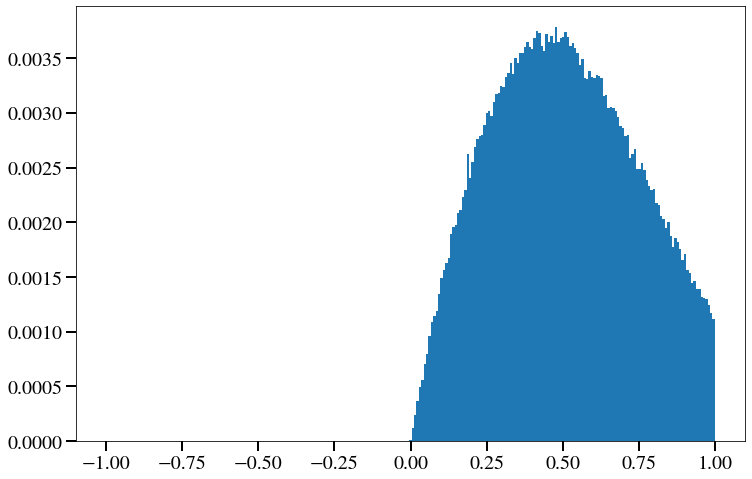

In [99]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    ( jmag_star / j_circ ),
    bins,
    weights = luminosity_in_gal,
)
fig

In [100]:
# Calculate fractions
weights = luminosity_in_gal * m_star
m_tot_weighted = weights.sum()
thin_disk_frac = weights[is_thin_disk].sum() / m_tot_weighted
thick_disk_frac = weights[is_thick_disk].sum() / m_tot_weighted

In [101]:
# Store
if 'thin_disk_fraction_sloanr' not in summary_data.keys():
    summary_data['thin_disk_fraction_sloanr'] = {}
summary_data['thin_disk_fraction_sloanr'][pm['variation']] = thin_disk_frac
if 'thick_disk_fraction_sloanr' not in summary_data.keys():
    summary_data['thick_disk_fraction_sloanr'] = {}
summary_data['thick_disk_fraction_sloanr'][pm['variation']] = thick_disk_frac

In [102]:
summary_data['jz_jmag_stars']['thin_disk_sloanr'][pm['variation']] = hist

In [103]:
summary_data.keys()

dict_keys(['Mstar', 'Mvir', 'R1e5K', 'R1e5K_rgal', 'Rstar0.5', 'Rvir', 'Vc', 'before_after_plot_data', 'cosphi', 'cosphi_stars', 'disk_half_height', 'disk_radius', 'f_thin_tracked_z0', 'jz_jmag_stars', 'jzjmag', 'n_tracked', 'quiet_acc_fraction', 'sigma_r', 't1e5_offset', 'thick_disk_fraction', 'thick_disk_fraction_recent', 'thick_disk_fraction_sloanr', 'thin_disk_fraction', 'thin_disk_fraction_recent', 'thin_disk_fraction_sloanr', 'tracked_mass_z0', 'tracked_star_mass_z0', 'v_rot'])

In [104]:
summary_data.to_hdf5( summary_fp )

### z/R Distribution
For thin-disk stars.

In [105]:
# Calculate phi
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir, )[is_in_gal_star]
costheta = z / s_data.get_data( 'R' )[is_in_gal_star]

In [106]:
bins = np.linspace( -1, 1, 256 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

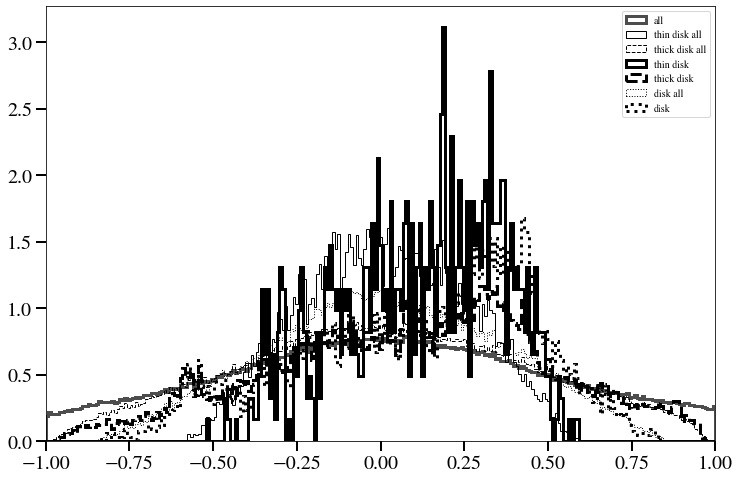

In [107]:
# Calc hists and plot
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

dist, bins, patches = ax.hist(
    costheta,
    bins,
    histtype = 'step',
    linewidth = 3,
    color = '0.3',
    density = True,
    label = 'all',
)

thin_disk_dist, bins, patches = ax.hist(
    costheta[is_thin_disk],
    bins,
    histtype = 'step',
    linewidth = 1,
    color = 'k',
    density = True,
    label = 'thin disk all',
)

dist, bins, patches = ax.hist(
    costheta[is_thick_disk],
    bins,
    histtype = 'step',
    linewidth = 1,
    color = 'k',
    density = True,
    label = 'thick disk all',
    linestyle = '--',
)

thin_disk_dist_recent, bins, patches = ax.hist(
    costheta[is_thin_disk & recent_in_gal],
    bins,
    histtype = 'step',
    linewidth = 3,
    color = 'k',
    density = True,
    label = 'thin disk',
)

dist, bins, patches = ax.hist(
    costheta[is_thick_disk & recent_in_gal],
    bins,
    histtype = 'step',
    linewidth = 3,
    color = 'k',
    density = True,
    label = 'thick disk',
    linestyle = '--',
)

disk_dist, bins, patches = ax.hist(
    costheta[is_disk],
    bins,
    histtype = 'step',
    linewidth = 1,
    color = 'k',
    density = True,
    label = 'disk all',
    linestyle = ':',
)

disk_dist_recent, bins, patches = ax.hist(
    costheta[is_disk & recent_in_gal],
    bins,
    histtype = 'step',
    linewidth = 3,
    color = 'k',
    density = True,
    label = 'disk',
    linestyle = ':',
)

ax.legend()

ax.set_xlim( -1, 1 )

fig

In [108]:
# Store
if 'cosphi_stars' not in summary_data:
    summary_data['cosphi_stars'] = {
        'thin_disk': {},
        'thin_disk_recent': {},
        'disk': {},
        'disk_recent': {},
        'centers': centers,
        'bins': bins,
    }

In [109]:
summary_data['cosphi_stars']['thin_disk'][pm['variation']] = thin_disk_dist
summary_data['cosphi_stars']['thin_disk_recent'][pm['variation']] = thin_disk_dist_recent

In [110]:
summary_data['cosphi_stars']['disk'][pm['variation']] = disk_dist
summary_data['cosphi_stars']['disk_recent'][pm['variation']] = disk_dist_recent

In [111]:
summary_data.to_hdf5( summary_fp )

### Disk Radius and Height

In [112]:
if 'disk_radius' not in summary_data:
    summary_data['disk_radius'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
        'recent_thin_disk_stars': {},
    }
if 'disk_half_height' not in summary_data:
    summary_data['disk_half_height'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
        'recent_thin_disk_stars': {},
    }

#### Gas

In [113]:
is_cold_gas = g_data.get_data( 'T' ) < 1.5e4

In [114]:
is_in_outer_boundary = g_data.get_data( 'R' ) < 0.15 * g_data.r_vir

In [115]:
r_cold_gas_in_boundary = g_data.get_data( 'R' )[is_cold_gas & is_in_outer_boundary]

In [116]:
r_d = np.percentile( r_cold_gas_in_boundary, 85 )

In [117]:
z = np.dot( g_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( g_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [118]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [119]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [120]:
half_height = np.percentile( z_in, 85 )

In [121]:
# Store
summary_data['disk_radius']['T<1.5e4 gas'][pm['variation']] = r_d
summary_data['disk_half_height']['T<1.5e4 gas'][pm['variation']] = half_height

In [122]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

Rd = 21.3, hd = 15, Rd/hd = 1.42


#### Stars

In [123]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.15 * s_data.r_vir

In [124]:
r_in_boundary = s_data.get_data( 'R' )[is_in_outer_boundary]

In [125]:
r_d = np.percentile( r_in_boundary, 85 )

In [126]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [127]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [128]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [129]:
half_height = np.percentile( z_in, 85 )

In [130]:
# Store
summary_data['disk_radius']['stars'][pm['variation']] = r_d
summary_data['disk_half_height']['stars'][pm['variation']] = half_height

In [131]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

Rd = 13.5, hd = 5.11, Rd/hd = 2.64


#### Young Stars

In [132]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.15 * s_data.r_vir

In [133]:
r_in_boundary = s_data.get_data( 'R' )[is_in_outer_boundary & recent]

In [134]:
r_d = np.percentile( r_in_boundary, 85 )

In [135]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [136]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [137]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [138]:
half_height = np.percentile( z_in, 85 )

In [139]:
# Store
summary_data['disk_radius']['recent_stars'][pm['variation']] = r_d
summary_data['disk_half_height']['recent_stars'][pm['variation']] = half_height

In [140]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

Rd = 8.89, hd = 4.34, Rd/hd = 2.05


#### Young Thin-Disk Stars

In [141]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.15 * s_data.r_vir

In [142]:
# Star masses enclosed
r_star = s_data.get_data( 'R' )[is_in_outer_boundary & recent]
r_star[r_star > s_data.r_vir] = np.nan
r_star_ckpc = r_star / ( h_param * ( 1. + s_data.redshift ) )
M_enc_star = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_star_ckpc
) / h_param

In [143]:
# Get grid masses enclose
r_grid = np.linspace( 0.00001, s_data.r_vir, 1024 )
r_grid_ckpc = r_grid / ( h_param * ( 1. + s_data.redshift ) )
M_enc_grid = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_grid_ckpc
) / h_param
M_enc_grid[np.isnan(M_enc_grid)] = 0.
M_enc_grid[np.arange(M_enc_grid.size)>np.argmax(M_enc_grid)] = M_enc_grid.max()

In [144]:
# Get potential energy
pot_grid = unyt.G * scipy.integrate.cumtrapz( M_enc_grid/r_grid**2., r_grid, initial=0 ) * unyt.Msun / unyt.kpc
pot_grid -= pot_grid[-1]
pot_grid -= unyt.G * g_data.m_vir * unyt.Msun / ( g_data.r_vir * unyt.kpc )
pot_grid = pot_grid.to( 'm**2/s**2' )
pot_fn = lambda x : scipy.interpolate.interp1d( r_grid, pot_grid )( x ) * unyt.m**2. / unyt.s**2.

In [145]:
# Get energy for a grid, using virial theorem
spec_e_grid = pot_grid + 0.5 * unyt.G * M_enc_grid * unyt.Msun / ( r_grid * unyt.kpc )

In [146]:
# Star potential energy, specific energy
pot_star = pot_fn( r_star )
v_star = s_data.get_data( 'Vmag' )[is_in_outer_boundary & recent] * unyt.km / unyt.s
spec_e_star =  pot_star +  0.5 * v_star**2.

In [147]:
# What radii particles would be at if they were circular with the same energy
spec_e_star[spec_e_star>spec_e_grid.max()] = np.nan
r_circ = scipy.interpolate.interp1d( spec_e_grid, r_grid )( spec_e_star )

In [148]:
# Circular momentum
r_circ_ckpc = r_circ / ( h_param * ( 1. + s_data.redshift ) )
M_enc_circ = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_circ_ckpc
) / h_param
j_circ = np.sqrt( unyt.G * M_enc_circ * unyt.Msun * r_circ * unyt.kpc)

In [149]:
# Angular momentum
ang_mom_dir = s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum )
l_units = unyt.Msun * unyt.kpc * unyt.km / unyt.s
lz_star = np.dot( s_data.get_data( 'L', ).transpose(), ang_mom_dir )[is_in_outer_boundary & recent] * l_units
lmag_star = s_data.get_data( 'Lmag' )[is_in_outer_boundary & recent] * l_units
m_star = s_data.get_data( 'M' )[is_in_outer_boundary & recent] * unyt.Msun
jz_star = lz_star / m_star
jmag_star = lmag_star / m_star

In [150]:
# Ratios
jz_jcirc_recent = jz_star / j_circ
jz_jmag_recent = jz_star / jmag_star
is_thin_disk = jz_jcirc_recent >= 0.8

In [151]:
r_in_boundary = s_data.get_data( 'R' )[is_in_outer_boundary & recent][is_thin_disk]

In [152]:
r_d = np.percentile( r_in_boundary, 85 )

In [153]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [154]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [155]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [156]:
half_height = np.percentile( z_in, 85 )

In [157]:
# Store
if 'recent_thin_disk_stars' not in summary_data['disk_radius']:
    summary_data['disk_radius']['recent_thin_disk_stars'] = {}
if 'recent_thin_disk_stars' not in summary_data['disk_half_height']:
    summary_data['disk_half_height']['recent_thin_disk_stars'] = {}
summary_data['disk_radius']['recent_thin_disk_stars'][pm['variation']] = r_d
summary_data['disk_half_height']['recent_thin_disk_stars'][pm['variation']] = half_height

In [158]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

Rd = 3.41, hd = 2.22, Rd/hd = 1.54


#### Finish Storing

In [159]:
summary_data.to_hdf5( summary_fp )

### Disk Rotational Velocity and Sigma

In [160]:
if 'v_rot' not in summary_data:
    summary_data['v_rot'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
    }
if 'sigma_r' not in summary_data:
    summary_data['sigma_r'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
    }

#### Gas

In [161]:
is_cold_gas = g_data.get_data( 'T' ) < 1.5e4

In [162]:
is_in_outer_boundary = g_data.get_data( 'R' ) < 0.1 * g_data.r_vir

In [163]:
r_in_boundary = g_data.get_data( 'R' )[is_in_outer_boundary & is_cold_gas]

In [164]:
r_e_cold_gas = np.percentile( r_in_boundary, 50 )

In [165]:
z = np.dot( g_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = g_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis]
r_perp_mag = np.linalg.norm( r_perp, axis=0 )

In [166]:
is_in_vertically = np.abs( z ) < 0.1
is_in_perpendicularly = r_perp_mag < 0.25 * r_e_cold_gas

In [167]:
# Calculate vtan
vz = np.dot( g_data.get_data( 'V' ).transpose(), ang_mom_dir )
s_hat = r_perp / r_perp_mag
vs = ( g_data.get_data( 'V' ) * s_hat ).sum( axis=0 )
vtan = g_data.get_data( 'V' ) - vz * ang_mom_dir[:,np.newaxis] - vs * s_hat
vtan_mag = np.linalg.norm( vtan, axis=0 )

In [168]:
vrot = np.mean( vtan_mag[is_in_vertically & is_in_perpendicularly & is_cold_gas] )

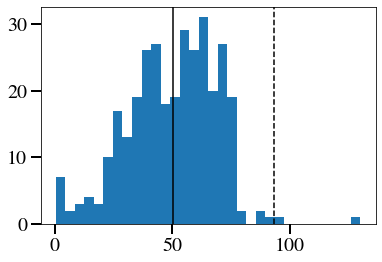

In [169]:
fig = plt.figure()
ax = plt.gca()

ax.hist(
    vtan_mag[is_in_vertically & is_in_perpendicularly],
    bins = 32,
)

ax.axvline(
    vrot,
    color = 'k',
)

vmax = s_data.halo_data.get_mt_data( 'Vmax', snums=[ snum, ] )
ax.axvline(
    vmax,
    color = 'k',
    linestyle = '--',
)

fig

In [170]:
r_hat = g_data.get_data( 'P' ) / g_data.get_data( 'R' )
vr = ( g_data.get_data( 'V' ) * r_hat ).sum( axis=0 )
masses = g_data.get_data( 'M' )

In [171]:
r_bins = np.linspace( 0, 0.1 * g_data.r_vir, 16 )
sigma_r = []
weights = []
for i, r_start in enumerate( tqdm.tqdm( r_bins[:-1] ) ):
    in_bin = ( g_data.get_data( 'R' ) > r_start ) & ( g_data.get_data( 'R' ) < r_bins[i+1] )
    
    sigma_r_i = np.std( vr[in_bin & is_cold_gas] )
    sigma_r.append( sigma_r_i )
    weights.append( masses[in_bin & is_cold_gas].sum() )
sigma_r = np.array( sigma_r )
weights = np.array( weights )

100%|██████████| 15/15 [00:00<00:00, 30.50it/s]


In [172]:
sigma_r = ( sigma_r * weights ).sum() / weights.sum()

In [173]:
# Store
summary_data['v_rot']['T<1.5e4 gas'][pm['variation']] = vrot
summary_data['sigma_r']['T<1.5e4 gas'][pm['variation']] = sigma_r

In [174]:
print( 'Vrot = {:.3g}, sigma = {:.3g}, Vrot/sigma = {:.3g}'.format( vrot, sigma_r, vrot / sigma_r ) )

Vrot = 50.1, sigma = 26.7, Vrot/sigma = 1.87


#### Stars

In [175]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.1 * s_data.r_vir

In [176]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis]
r_perp_mag = np.linalg.norm( r_perp, axis=0 )

In [177]:
is_in_vertically = np.abs( z ) < 0.1
is_in_perpendicularly = r_perp_mag < 0.25 * r_e_cold_gas

In [178]:
# Calculate vtan
vz = np.dot( s_data.get_data( 'V' ).transpose(), ang_mom_dir )
s_hat = r_perp / r_perp_mag
vs = ( s_data.get_data( 'V' ) * s_hat ).sum( axis=0 )
vtan = s_data.get_data( 'V' ) - vz * ang_mom_dir[:,np.newaxis] - vs * s_hat
vtan_mag = np.linalg.norm( vtan, axis=0 )

In [179]:
vrot = np.mean( vtan_mag[is_in_vertically & is_in_perpendicularly] )

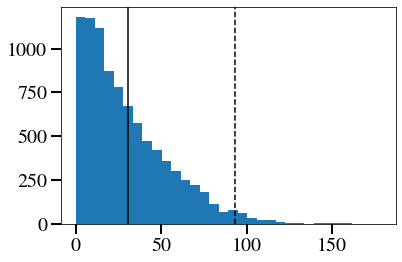

In [180]:
fig = plt.figure()
ax = plt.gca()

ax.hist(
    vtan_mag[is_in_vertically & is_in_perpendicularly],
    bins = 32,
)

ax.axvline(
    vrot,
    color = 'k',
)

vmax = s_data.halo_data.get_mt_data( 'Vmax', snums=[ snum, ] )
ax.axvline(
    vmax,
    color = 'k',
    linestyle = '--',
)

fig

In [181]:
r_hat = s_data.get_data( 'P' ) / s_data.get_data( 'R' )
vr = ( s_data.get_data( 'V' ) * r_hat ).sum( axis=0 )
masses = s_data.get_data( 'M' )

In [182]:
r_bins = np.linspace( 0, 0.1 * s_data.r_vir, 16 )
sigma_r = []
weights = []
for i, r_start in enumerate( tqdm.tqdm( r_bins[:-1] ) ):
    in_bin = ( s_data.get_data( 'R' ) > r_start ) & ( s_data.get_data( 'R' ) < r_bins[i+1] )
    
    sigma_r_i = np.std( vr[in_bin] )
    sigma_r.append( sigma_r_i )
    weights.append( masses[in_bin].sum() )
sigma_r = np.array( sigma_r )
weights = np.array( weights )

100%|██████████| 15/15 [00:00<00:00, 545.25it/s]


In [183]:
sigma_r = ( sigma_r * weights ).sum() / weights.sum()

In [184]:
# Store
summary_data['v_rot']['stars'][pm['variation']] = vrot
summary_data['sigma_r']['stars'][pm['variation']] = sigma_r

In [185]:
print( 'Vrot = {:.3g}, sigma = {:.3g}, Vrot/sigma = {:.3g}'.format( vrot, sigma_r, vrot / sigma_r ) )

Vrot = 30.3, sigma = 43.2, Vrot/sigma = 0.701


#### Young Stars

In [186]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.1 * s_data.r_vir

In [187]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis]
r_perp_mag = np.linalg.norm( r_perp, axis=0 )

In [188]:
is_in_vertically = np.abs( z ) < 0.1
is_in_perpendicularly = r_perp_mag < 0.25 * r_e_cold_gas

In [189]:
# Calculate vtan
vz = np.dot( s_data.get_data( 'V' ).transpose(), ang_mom_dir )
s_hat = r_perp / r_perp_mag
vs = ( s_data.get_data( 'V' ) * s_hat ).sum( axis=0 )
vtan = s_data.get_data( 'V' ) - vz * ang_mom_dir[:,np.newaxis] - vs * s_hat
vtan_mag = np.linalg.norm( vtan, axis=0 )

In [190]:
vrot = np.mean( vtan_mag[is_in_vertically & is_in_perpendicularly & recent] )

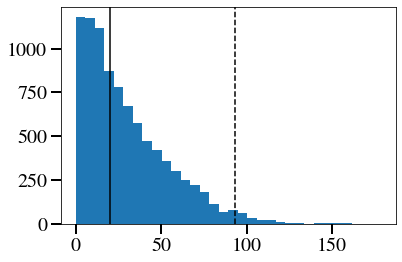

In [191]:
fig = plt.figure()
ax = plt.gca()

ax.hist(
    vtan_mag[is_in_vertically & is_in_perpendicularly],
    bins = 32,
)

ax.axvline(
    vrot,
    color = 'k',
)

vmax = s_data.halo_data.get_mt_data( 'Vmax', snums=[ snum, ] )
ax.axvline(
    vmax,
    color = 'k',
    linestyle = '--',
)

fig

In [192]:
r_hat = s_data.get_data( 'P' ) / s_data.get_data( 'R' )
vr = ( s_data.get_data( 'V' ) * r_hat ).sum( axis=0 )
masses = s_data.get_data( 'M' )

In [193]:
r_bins = np.linspace( 0, 0.1 * s_data.r_vir, 16 )
sigma_r = []
weights = []
for i, r_start in enumerate( tqdm.tqdm( r_bins[:-1] ) ):
    in_bin = ( s_data.get_data( 'R' ) > r_start ) & ( s_data.get_data( 'R' ) < r_bins[i+1] )
    
    sigma_r_i = np.std( vr[in_bin & recent] )
    sigma_r.append( sigma_r_i )
    weights.append( masses[in_bin & recent].sum() )
sigma_r = np.array( sigma_r )
weights = np.array( weights )

100%|██████████| 15/15 [00:00<00:00, 573.76it/s]


In [194]:
sigma_r = ( sigma_r * weights ).sum() / weights.sum()

In [195]:
# Store
summary_data['v_rot']['recent_stars'][pm['variation']] = vrot
summary_data['sigma_r']['recent_stars'][pm['variation']] = sigma_r

In [196]:
print( 'Vrot = {:.3g}, sigma = {:.3g}, Vrot/sigma = {:.3g}'.format( vrot, sigma_r, vrot / sigma_r ) )

Vrot = 19.8, sigma = 29.9, Vrot/sigma = 0.663


#### Finish Storing

In [197]:
summary_data.to_hdf5( summary_fp )

# Firefly Visualization

## Format Data

### Raw Data

In [263]:
coords = s_data.get_data( 'P' )[:,is_in_gal_star].transpose()

In [264]:
velocities = s_data.get_data( 'V' )[:,is_in_gal_star].transpose()

In [265]:
fields_dict = {
    'Age': lookback_time[is_in_gal_star],
    'Circularity': jz_jcirc.value,
    'MomentumAngle': jz_jmag.value,
}

### Sample Indices

In [266]:
inds = np.arange( coords.shape[0] )

In [267]:
premask = lookback_time[is_in_gal_star] < 1.
if premask is not None:
    inds = inds[premask]

In [268]:
n_max = 1000000
if inds.size > n_max:
    inds = np.random.choice( inds, n_max, replace=False )
coords = coords[inds,:]
velocities = velocities[inds,:]

In [269]:
fields = []
field_names = []
for key, item in fields_dict.items():
    item = item[inds]
    fields.append( item )
    field_names.append( key )

In [270]:
fields = np.array( fields )

### Transfer to Reader

In [271]:
import Firefly.data_reader as firefly_readers

In [272]:
reader = firefly_readers.ArrayReader(
    coords,
    fields = fields,
    field_names = field_names,
    write_jsons_to_disk = False,
)

JSONdir is None, defaulting to /home1/03057/zhafen/repos/Firefly/src/Firefly/static/data/Data
Make sure each tracked_array (3) has a tracked_filter_flag (0), assuming True.
Make sure each tracked_array (3) has a tracked_colormap_flag (0), assuming True.
Outputting: PGroup_0 - 80221/80221 particles - 3 tracked fields


In [273]:
reader.settings['sizeMult']['PGroup_0'] = 0.01

In [ ]:
# reader.settings.printKeys()

## View Data

In [275]:
from Firefly.server import spawnFireflyServer, killAllFireflyServers

In [279]:
if pm['inline_firefly']:
    process = spawnFireflyServer(9299)

Waiting up to 10 seconds for background Firefly server to start......done! Your server is available at - http://localhost:9299


In [280]:
if pm['inline_firefly']:
    reader.sendDataViaFlask(9299)

Posting...data posted!


In [281]:
if pm['inline_firefly']:
    killAllFireflyServers()